## LangGraph로 에이전트 시스템 만들기
Supervision 다중 에이전트 시스템으로 주식 종목 평가하기

In [1]:
from dotenv import load_dotenv
import os

load_dotenv()

True

### 웹검색과 코드 실행도구 정의

In [2]:
from typing import Annotated
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_experimental.tools import PythonREPLTool

tavily_tool = TavilySearchResults(max_results=5)
python_repl_tool = PythonREPLTool()

/var/folders/l_/8kygc87n5q1d13jbjvmg1mdm0000gn/T/ipykernel_42044/114800678.py:5: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily_tool = TavilySearchResults(max_results=5)


### 최근 주가 및 재무 분석 도구 정의

In [3]:
import yfinance as yf
from datetime import datetime, timedelta
import pandas as pd

ticker = yf.Ticker("NVDA")
historical_prices = ticker.history(period="5d", interval="1d")

last_5_days_close = historical_prices["Close"].tail(5)
last_5_days_close_dict = {
    date.strftime("%Y-%m-%d"): price for date, price in last_5_days_close.items()
}
# 연간 및 분기별 재무제표 데이터 가져오기
last_5_days_close_dict

{'2025-07-01': 153.3000030517578,
 '2025-07-02': 157.25,
 '2025-07-03': 159.33999633789062,
 '2025-07-07': 158.24000549316406,
 '2025-07-08': 160.0}

In [4]:
from langchain.tools import BaseTool, StructuredTool, tool

재무 분석 도구

In [5]:
@tool
def stock_analysis(ticker: str) -> str:
    """
    주어진 주식 티커에 대한 업데이트된 종합적인 재무 분석을 수행합니다.
    최신 주가 정보, 재무 지표, 성장률, 밸류에이션 및 주요 비율을 제공합니다.
    가장 최근 영업일 기준의 데이터를 사용합니다.

    :param ticker: 분석할 주식의 티커 심볼
    :return: 재무 분석 결과를 포함한 문자열
    """

    def format_number(number):
        if number is None or pd.isna(number):
            return "N/A"
        return f"{number:,.0f}"

    def format_financial_summary(financials):
        summary = {}
        for date, data in financials.items():
            date_str = date.strftime("%Y-%m-%d")
            summary[date_str] = {
                "총수익": format_number(data.get("TotalRevenue")),
                "영업이익": format_number(data.get("OperatingIncome")),
                "순이익": format_number(data.get("NetIncome")),
                "EBITDA": format_number(data.get("EBITDA")),
                "EPS(희석)": (
                    f"${data.get('DilutedEPS'):.2f}"
                    if pd.notna(data.get("DilutedEPS"))
                    else "N/A"
                ),
            }
        return summary

    ticker = yf.Ticker(ticker)
    historical_prices = ticker.history(period="5d", interval="1d")

    last_5_days_close = historical_prices["Close"].tail(5)
    last_5_days_close_dict = {
        date.strftime("%Y-%m-%d"): price for date, price in last_5_days_close.items()
    }
    # 연간 및 분기별 재무제표 데이터 가져오기
    annual_financials = ticker.get_financials()
    quarterly_financials = ticker.get_financials(freq="quarterly")

    return str(
        {
            "최근 5일간 종가": last_5_days_close_dict,
            "연간 재무제표 요약": format_financial_summary(annual_financials),
            "분기별 재무제표 요약": format_financial_summary(quarterly_financials),
        }
    )

### Supervisor Agent

In [6]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_openai import ChatOpenAI
from pydantic import BaseModel
from typing import Literal

In [7]:
members = ["Researcher", "Stock_Analyzer", "Chart_Generator"]
system_prompt = (
    "You are a supervisor tasked with managing a conversation between the"
    " following workers:  {members}. Given the following user request,"
    " respond with the worker to act next. Each worker will perform a"
    " task and respond with their results and status. When finished,"
    " respond with FINISH."
)
# Our team supervisor is an LLM node. It just picks the next agent to process
# and decides when the work is completed
options = ["FINISH"] + members

In [8]:
class routeResponse(BaseModel):
    next: Literal[*options]

prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next?"
            " Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(options), members=", ".join(members))


llm = ChatOpenAI(model="gpt-4o-mini")

def supervisor_agent(state):
    supervisor_chain = (
        prompt
        | llm.with_structured_output(routeResponse)
    )
    return supervisor_chain.invoke(state)

### 하위 에이전트 정의

In [9]:
from langchain_core.messages import HumanMessage


def agent_node(state, agent, name):
    result = agent.invoke(state)
    return {
        "messages": [HumanMessage(content=result["messages"][-1].content, name=name)]
    }

하위 에이전트 설정

In [10]:
import functools
import operator
from typing import Sequence, TypedDict

from langchain_core.messages import BaseMessage

from langgraph.graph import END, StateGraph, START
from langgraph.prebuilt import create_react_agent


# The agent state is the input to each node in the graph
class AgentState(TypedDict):
    # The annotation tells the graph that new messages will always
    # be added to the current states
    messages: Annotated[Sequence[BaseMessage], operator.add]
    # The 'next' field indicates where to route to next
    next: str


research_system_prompt = """You are a helpful research analyst who is specialized in 
gathering valuable info for given stock."""
research_agent = create_react_agent(
    llm, tools=[tavily_tool], prompt=research_system_prompt
)
research_node = functools.partial(agent_node, agent=research_agent, name="Researcher")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
stock_system_prompt = """You are a helpful Stock and financial analyst. Never hallucinate the given metrics."""
stock_agent = create_react_agent(
    llm, tools=[stock_analysis], prompt=stock_system_prompt
)
stock_node = functools.partial(agent_node, agent=stock_agent, name="Stock_Analyzer")

# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION. PROCEED WITH CAUTION
chart_system_prompt = """You are a helpful Stock Chart Generator. 
Only make accurate charts for given query. Chart design and accuracy should be state of the art.
Never make any other mention."""
chart_agent = create_react_agent(
    llm, tools=[python_repl_tool], prompt=chart_system_prompt
)
chart_node = functools.partial(agent_node, agent=chart_agent, name="Chart_Generator")

workflow = StateGraph(AgentState)
workflow.add_node("Researcher", research_node)
workflow.add_node("Stock_Analyzer", stock_node)
workflow.add_node("Chart_Generator", chart_node)
workflow.add_node("supervisor", supervisor_agent)

In [11]:
members

['Researcher', 'Stock_Analyzer', 'Chart_Generator']

In [12]:
for member in members:
    # We want our workers to ALWAYS "report back" to the supervisor when done
    workflow.add_edge(member, "supervisor")
# The supervisor populates the "next" field in the graph state
# which routes to a node or finishes
conditional_map = {k: k for k in members}
conditional_map["FINISH"] = END
workflow.add_conditional_edges("supervisor", lambda x: x["next"], conditional_map)
# Finally, add entrypoint
workflow.add_edge(START, "supervisor")

graph = workflow.compile()

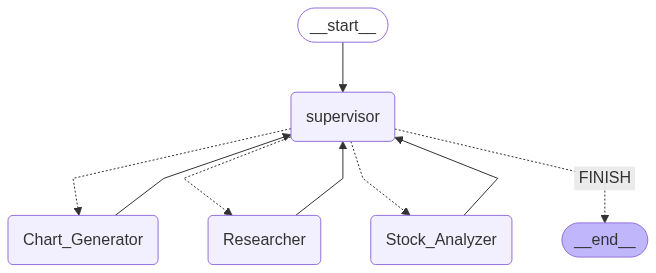

In [13]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

{'supervisor': {'next': 'Researcher'}}
----
{'Researcher': {'messages': [HumanMessage(content='현재 애플 주식에 대한 최신 정보를 가져오는 데 문제가 발생했습니다. 하지만 애플 주식을 구매하는 데 도움이 될 수 있는 일반적인 요소들을 제공할 수 있습니다.\n\n1. **재무 실적**: 애플의 최근 수익 보고서와 재무 지표를 확인하세요. 매출 성장, 순이익, 부채 비율 등을 살펴보는 것이 중요합니다.\n\n2. **시장 동향**: 기술주에 대한 시장의 전반적인 분위기를 고려하세요. 경제 지표나 금리 인상과 관련된 뉴스가 애플 주식에 미치는 영향을 분석하는 것이 필요합니다.\n\n3. **경쟁사 분석**: 애플의 주요 경쟁사인 삼성, 구글, 마이크로소프트 등의 최근 성과를 비교해 보세요. 경쟁사들이 새로운 제품을 출시하거나 시장 점유율을 확대하는 경우 애플에 영향을 미칠 수 있습니다.\n\n4. **제품 출시 일정**: 애플이 예정한 신제품 출시 일정이나 서비스 확장 계획이 있는지 확인하세요. 새로운 아이폰, 아이패드, 또는 서비스의 출시가 주가에 긍정적인 영향을 미칠 수 있습니다.\n\n5. **전문가 의견**: 애널리스트들의 목표 주가와 투자 의견을 참고하세요. 전문가들의 의견은 주식 투자 결정에 중요한 요소가 될 수 있습니다.\n\n이 외에도 특정 질문이나 추가 정보가 필요하시면 말씀해 주세요.', additional_kwargs={}, response_metadata={}, name='Researcher')]}}
----
{'supervisor': {'next': 'Stock_Analyzer'}}
----
{'Stock_Analyzer': {'messages': [HumanMessage(content='애플(AAPL) 주식에 대한 최신 재무 분석 결과는 다음과 같습니다.\n\n### 최근 주가 동향 (최근 5일)\n- **2025-07-01**: $207.82\n- **2025-07

Python REPL can execute arbitrary code. Use with caution.


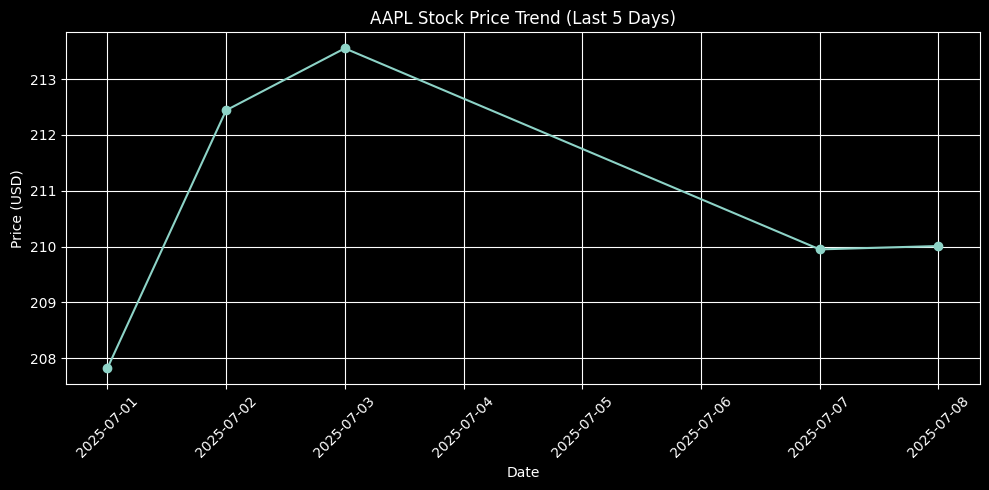

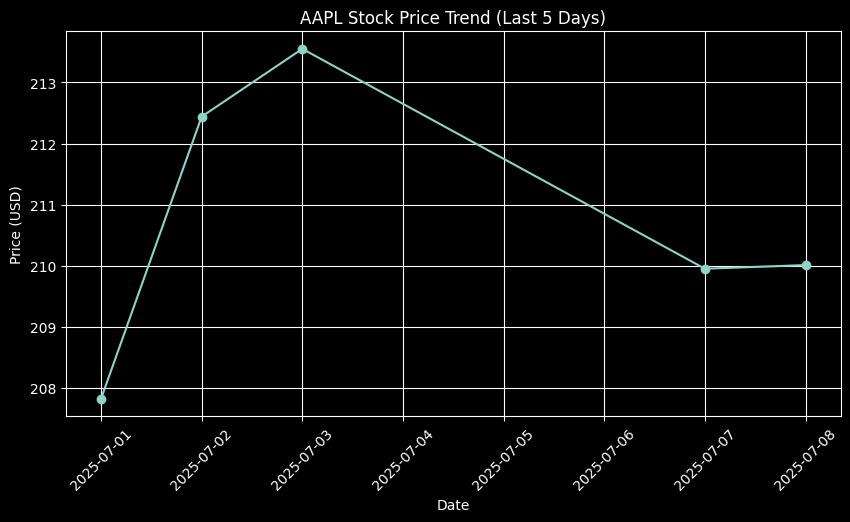

KeyboardInterrupt: 

In [14]:
for s in graph.stream(
    {"messages": [HumanMessage(content="애플 주식 구매 의사 결정 도와줘")]}
):
    if "__end__" not in s:
        print(s)
        print("----")

- 차트 생성 후 멈춤
- 추후 다시 할 것